## COMP3670/6670 Programming Assignment 4 - Gaussian mixture models ##
---

**Enter Your Student ID: u7689173**

**Your Name: Aryan Odugoudar**
    
**Deadline:** Monday 23 October 23:59pm

**Submit:** Write your answers in this file, and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Note: you don't need to submit the .png or .npy files. 

**Enter Discussion Partner IDs Below:**
- u7146196
- u7701030
- https://sharmaeklavya2.github.io/theoremdep/nodes/linear-algebra/eigenvectors/distinct-eigenvalue-linindep.html

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
np.random.seed(42)

### **Task 0: Warming Up** ###

We first load and visualise the data, initialise the Gaussian mixture components randomly and visualise them.

number of data points 120
number of dimensions 2


Text(0, 0.5, '$x_2$')

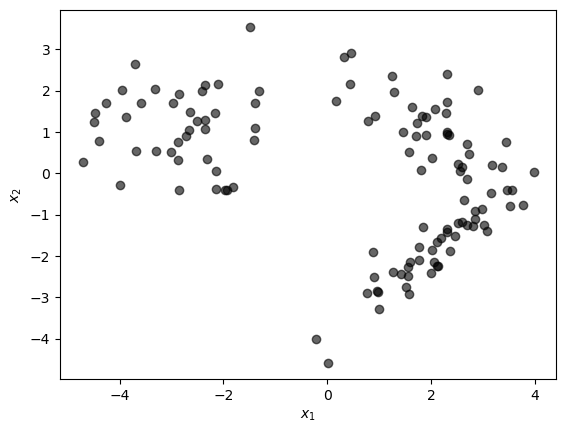

In [4]:
# load data
x = np.loadtxt("./data/gmm_data.txt")
N, D = x.shape[0], x.shape[1]

print("number of data points %d" % N)
print("number of dimensions %d" % D)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], color='k', alpha=0.6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [5]:
def viz_mixture(X, mus, Sigmas, suffix=''):
    # code to visualise the Gaussian components
    # X is data, N x D. N: number of datapoints, D: dimensions
    # mus contains means, K x D, K: number of Gaussian components
    # Sigmas contains covariances, K x D x D.
    
    plt.figure()
    ax = plt.subplot(111)
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    K = mus.shape[0]
    for k in range(K):
        m = mus[k, :]
        cov = Sigmas[k, :, :]
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        from matplotlib.patches import Ellipse
        for j in range(1, 4):
            ell = Ellipse(xy=m,
                        width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                        angle=np.rad2deg(np.arccos(v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(CB_color_cycle[k])
            ax.add_artist(ell)
    plt.scatter(x[:, 0], x[:, 1], color='k', alpha=0.6)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.xlim([-8, 8])
    plt.ylim([-8, 8])

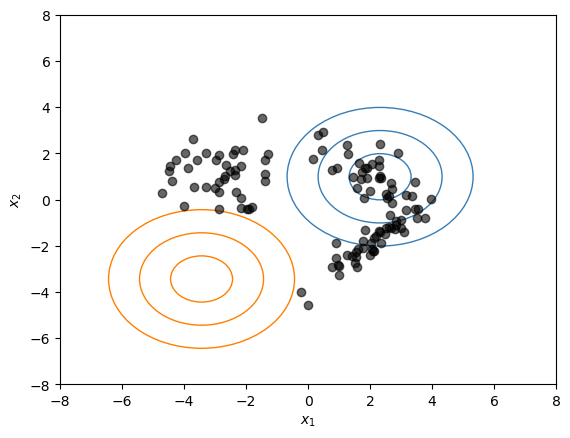

In [6]:
# initialise the mixture components randomly 
K = 2 
init_pis = np.random.rand(K) 
init_pis = init_pis / np.sum(init_pis)
init_mus = np.random.uniform(-5, 5, K * D).reshape(K, D)
init_Sigmas = np.array([np.eye(D) for _ in range(K)])

# visualise
viz_mixture(x, init_mus, init_Sigmas)

### **Task 1: Computing GMM log-likelihood** ###

The GMM log-likelihood for N data points is:
$$
  \log p(x | \theta) = \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)
$$

Write a function to compute the log-likelihood of the GMMs parameters given data. 

Hint: have a look at Week 9's tutorial and the `compute_responsibility` function in Task 2 below.


In [7]:
def gmm_log_likelihood(x, mus, Sigmas, pis):
    # x is data, N x D. N: number of datapoints, D: dimensions
    # mus contains means, K x D, K: number of Gaussian components.
    # Sigmas contains covariances, K x D x D.
    # pis contains the mixture weights, of size K.
    # this function should return a number
    
    N, D = x.shape
    K = len(pis)
    log_likelihood = 0

    for n in range(N):
        llh = np.zeros(K)
        for k in range(K):
          
            llh[k] = pis[k] * multivariate_normal.pdf(x[n], mean=mus[k], cov=Sigmas[k])
            
        log_likelihood += np.log(np.sum(llh))
    
    return log_likelihood

In [8]:
# we can compute the log likelihood of the initial parameters
loglik = gmm_log_likelihood(x, init_mus, init_Sigmas, init_pis)
print(loglik)

-949.6169521065037


### **Task 2: Estimate GMM parameters** ###

In Week 9's tutorial, you have implemented the E-step of the EM algorithm for GMMs to compure the assignment probability (see `compute_responsibility` below) . Your next task is to implement the updates required in the M-step.
$$
\mu_k = \frac{1}{N_k} \sum_{n=1}^{N} r_{nk} x_n, \quad N_k = \sum_{n=1}^N r_{nk}
$$
$$
\Sigma_k = \frac{1}{N_k} \sum_{n=1}^Nr_{nk}(x_n - \mu_k)(x_n-\mu_k)^\intercal
$$
$$
\pi_k = \frac{N_k}{N}
$$
Note that we are not asking you to handle the singularity issue in your code, just implement the updates above.

In [9]:
def compute_responsibility(x, mus, Sigmas, pis):
    logpdfs = np.array([multivariate_normal.logpdf(x, mean=mus[k, :], cov=Sigmas[k, :, :]) for k in range(K)])
    logpi = np.log(pis)
    logpin = logpi[:, None] + logpdfs
    denom = logsumexp(logpin, axis=0)
    logres = logpin - denom[None, :]
    res = np.exp(logres).T
    return res
    
def update_mean(x, r):
    # x is data, N x D
    # r is responsibility, N x K
    
    # This function should return the new means, K x D
    Nk = np.sum(r, axis=0)[:, np.newaxis]  
    means = np.dot(r.T,x) / Nk  
    return means

def update_cov(x, r, mus):
    # x is data, N x D
    # r is responsibility, N x K
    # mus is the current means, K x D
    
    # This function should return the new covariances, K x D x D
    
    Nk = np.sum(r, axis=0)[:, np.newaxis] 
    covariances = np.zeros((K, D, D))
    for k in range(K):
        diff = x - mus[k, :]  
        covariances[k, :, :] = np.dot(r[:, k] * diff.T, diff) / Nk[k]
    return covariances

def update_pi(r):
    # r is responsibility, N x K
    # This function should return the new mixture weights, of length K
    Nk = np.sum(r, axis=0)  
    pi = Nk / N
    return pi

    

We now run a few EM iterations and and visualise the resulting mixture. Since we are not handling issues such as singularity, the following code block may fail. If that happens, try to reinitialise using the final code block in task 0.

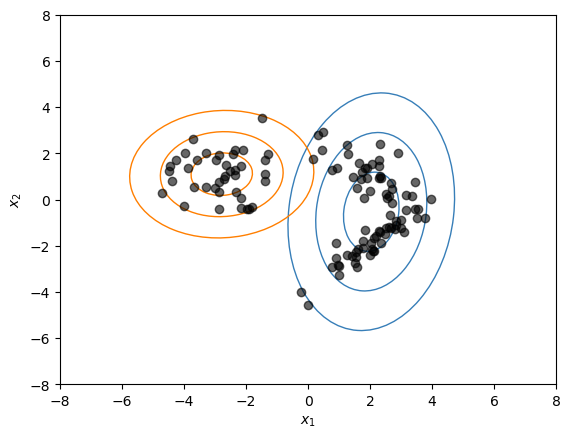

In [10]:
no_iters = 100
mus, Sigmas, pis = init_mus, init_Sigmas, init_pis
for i in range(no_iters):
    r = compute_responsibility(x, mus, Sigmas, pis)
    mus = update_mean(x, r)
    Sigmas = update_cov(x, r, mus)
    pis = update_pi(r)
viz_mixture(x, mus, Sigmas)

### **Task 3: Understanding the likelihood** ###

**Task 3.1**

In Task 1, you have computed the likelihood of the initial parameters. We can also compute the likelihood of the parameters given by EM. Compare the two likelihoods and comment.

In [34]:
loglik = gmm_log_likelihood(x, mus, Sigmas, pis)
print(loglik)

-445.6603004333964


Here we can see that the the log - likelihood obtined from the EM parameters is -445.6603004333964 which is higher than the log-likelihood obtained from the initial parameters -949.6169521065037, it means that the EM algorithm has found a set of parameters that explains the given data in a better way than the initial parameters.

The model with the EM parameters has better fit

**Task 3.2**

We can also evaluate the log likelihood given new test points. We will next visualise the log-likelihoods computed on training data and validation data when varying the number of mixture components. Comment on the result.

Text(0, 0.5, 'log-likelihood')

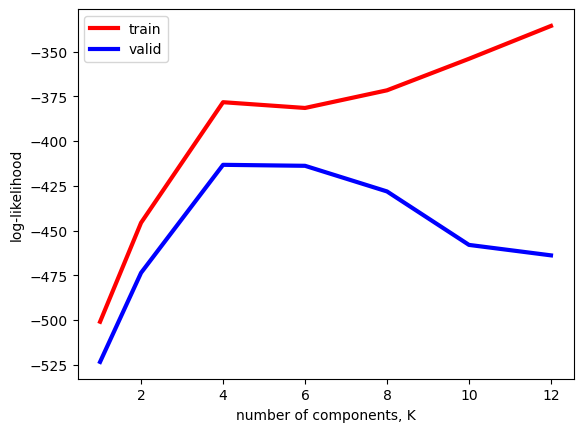

In [35]:
x_valid = np.loadtxt("./data/gmm_data_valid.txt")
Ks = [1, 2, 4, 6, 8, 10, 12]
no_iters = 100
lik_train = []
lik_valid = []
for K in Ks:
    while True:
        try:
            init_pis = np.random.rand(K) 
            init_pis = init_pis / np.sum(init_pis)
            init_mus = np.random.uniform(-5, 5, K * D).reshape(K, D)
            init_Sigmas = np.array([np.eye(D) for _ in range(K)])
            mus, Sigmas, pis = init_mus, init_Sigmas, init_pis
            for i in range(no_iters):
                r = compute_responsibility(x, mus, Sigmas, pis)
                mus = update_mean(x, r)
                Sigmas = update_cov(x, r, mus)
                pis = update_pi(r)
            lik_train.append(gmm_log_likelihood(x, mus, Sigmas, pis))
            lik_valid.append(gmm_log_likelihood(x_valid, mus, Sigmas, pis))
            break
        except:
            # We just have another random restart
            continue
plt.figure()
plt.plot(Ks, lik_train, color='r', lw=3, label='train')
plt.plot(Ks, lik_valid, color='b', lw=3, label='valid')
plt.legend()
plt.xlabel('number of components, K')
plt.ylabel('log-likelihood')

After computing log - likelihood on both training and validation data we can conclude that
- As the number of components (K) increases, the model complexity also increases. This generally allows the model to capture more difficult patterns in the data.

- The training log-likelihood tends to increase with a higher number of components because the model becomes more flexible. It can fit the training data more closely, leading to higher likelihood values.

- However, the validation log-likelihood might not always follow the same trend. An overly complex model can lead to overfitting, where it fits the noise in the training data rather than capturing the underlying patterns. This can cause the validation log-likelihood to decrease for very high values of K.

- There is often a point of diminishing returns, where adding more components does not significantly improve the model's ability to generalize to unseen data (validation data). This point is usually a good choice for the number of components in the GMM, balancing model complexity and generalization performance.

Overall, the plot of log-likelihood values provides insights into the trade-off between model complexity and generalization. It helps in selecting an appropriate number of components for the GMM, which is a crucial decision in probabilistic modeling.